In [15]:
import festim as F
import numpy as np
from fenics import UnitSquareMesh, MeshFunction

my_model = F.Simulation()

half_life = 0

my_model.initial_conditions = [F.InitialCondition(value=1, field="solute")]

my_model.dt = F.Stepsize(
    initial_value=0.05,
    stepsize_change_ratio=1.01,
    dt_min=1e-05,
)

derived_quantities = F.DerivedQuantities([  
    F.TotalVolume("solute", volume=1)
])

my_model.exports = [derived_quantities]

# irrelevant quantities
my_model.materials = [F.Material(id=1, D_0=4.1e-07, E_D=0.39)]
my_model.T = F.Temperature(value=300)

class RadioactiveDecayModel1D:
    def __init__(self, half_life):
        # radioactive decay conditions on 1m^3 space
        my_model.mesh = F.MeshFromVertices(np.linspace(0, 1, 1001))

        my_model.sources = [
            F.RadioactiveDecay(decay_constant=np.log(2) / half_life, volume=1)
        ]

        my_model.settings = F.Settings(
            absolute_tolerance=1e-13,
            relative_tolerance=1e-10,
            final_time=6*half_life  # s
        )

        my_model.initialise()
        my_model.run()

        self.time = derived_quantities.t
        self.concentration = derived_quantities[0].data

class RadioactiveDecayModel2D:
    def __init__(self, half_life):
        nx, ny = 10, 10
        mesh_fenics = UnitSquareMesh(nx, ny)

        volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())
        volume_markers.set_all(1)

        my_model.mesh = F.Mesh(mesh_fenics, volume_markers=volume_markers)

        my_model.sources = [
            F.RadioactiveDecay(decay_constant=np.log(2) / half_life, volume=1)
        ]

        my_model.settings = F.Settings(
            absolute_tolerance=1e-13,
            relative_tolerance=1e-10,
            final_time=6*half_life  # s
        )

        my_model.initialise()
        my_model.run()

        self.time = derived_quantities.t
        self.concentration = derived_quantities[0].data

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/rekomodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        6.0e+02 s    Ellapsed time so far: 1.4 s


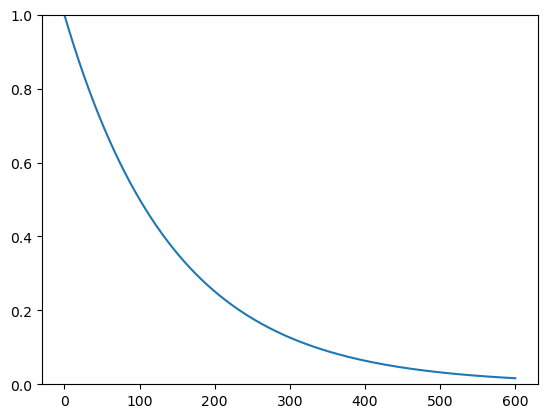

In [16]:
model_1 = RadioactiveDecayModel2D(half_life=100)
t, concentration = model_1.time, model_1.concentration

import matplotlib.pyplot as plt

plt.plot(t, concentration, scaley=False)